In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [2]:
import string
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [4]:
from sklearn.metrics import classification_report

In [5]:
df_train = pd.read_csv('./dataset/twitter_training.csv', header=None)
df_train.shape

(74682, 4)

In [6]:
df_train.head()

,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [7]:
df_test = pd.read_csv('./dataset/twitter_validation.csv', header=None)
df_test.shape

(1000, 4)

In [8]:
df_test.head()

,0,1,2,3
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


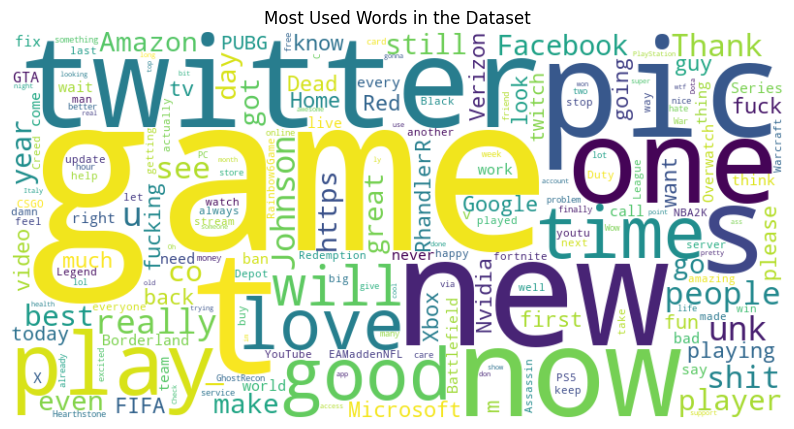

In [9]:
# Displaying some of the popular words in the dataset using wordcloud

text = " ".join(f'{cat}' for cat in df_train[3])
word_cloud = WordCloud(background_color='white', width=800, height=400, collocations=False, random_state=666).generate(text)
plt.figure(figsize=(10, 10))
plt.title('Most Used Words in the Dataset')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [10]:
porter = PorterStemmer()

def preprocess_string(review_string):
    review_string = f'{review_string}'
    review_string = review_string.translate(str.maketrans('', '', string.punctuation)) # REmoving punctuations
    review_string = word_tokenize(review_string)
    stemmed_text = ' '.join([porter.stem(word) for word in review_string]) # Rejoiniing the stemmed tokens into a single sentence after stemming

    return stemmed_text

In [11]:
vectorized_preprocess = np.vectorize(preprocess_string) # vectorizing so that, the function that acts like pyfunc, but takes arrays as input. 

In [12]:
X_train = vectorized_preprocess(df_train[3]) 
X_test = vectorized_preprocess(df_test[3]) 

In [13]:
y_train = df_train[2]
y_test = df_test[2]

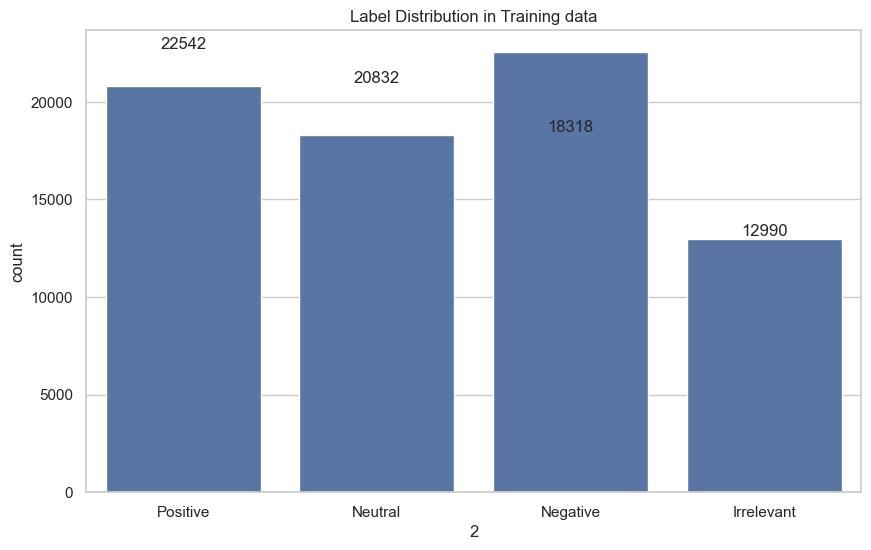

In [14]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.title('Label Distribution in Training data')
ax = sns.countplot(x=y_train)
for index, value in enumerate(y_train.value_counts()):
    ax.text(index, value, str(value,), ha='center', va='bottom')
plt.show()

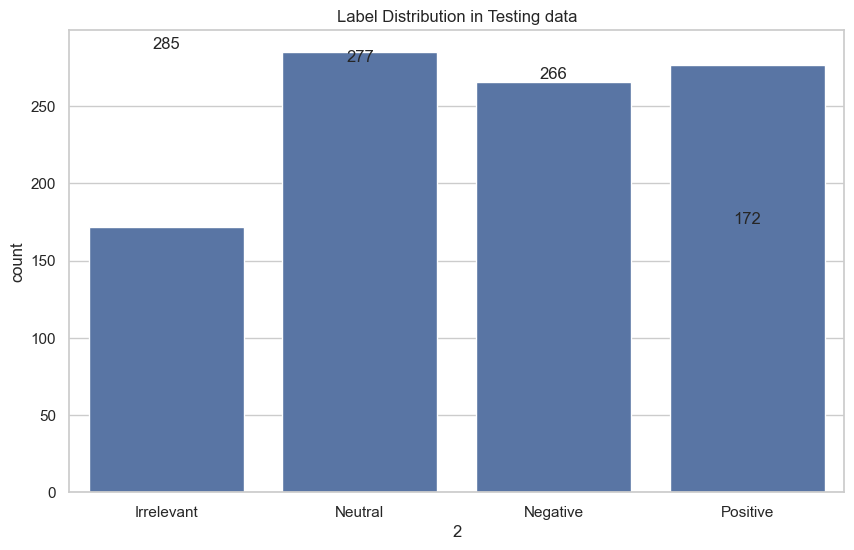

In [15]:
np.unique(y_test, return_counts=True)

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.title('Label Distribution in Testing data')
ax = sns.countplot(x=y_test)
for index, value in enumerate(y_test.value_counts()):
    ax.text(index, value, str(value,), ha='center', va='bottom')
plt.show()

In [16]:
# Vectorizing the dataset using tfidf vectorizer. max_features is set to 4096 due to the limitation on computing resourse.
vectorizer = TfidfVectorizer(tokenizer=nltk.word_tokenize, stop_words='english', lowercase=True, ngram_range=(1, 1), max_features=4096)

In [17]:
# Fitting and transforming the training set
X_train = vectorizer.fit_transform(X_train, )
X_train.shape

C:\Users\Prabesh Lamichhane\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(74682, 4096)

In [18]:
# Transforming the test set using the knowledge gained from the training set
X_test = vectorizer.transform(X_test)

In [19]:
models = {
    'RandomForestClassifier': RandomForestClassifier(n_jobs=-1, random_state=666),
    # 'GradientBoostingClassifier': GradientBoostingClassifier(random_state=666)
}

In [20]:
params = {'RandomForestClassifier': {'n_estimators': [100, 150, 200],
                                     'max_depth': [100, 120,],
                                    },
          'GradientBoostingClassifier': {'n_estimators': [20, 35, 50],
                                         'max_depth': [3, 5, 9,],
                           }
             }

In [22]:
grid_search = dict()

In [23]:
%%time
for each_model in models:
    print(f'Cross Validating {each_model}\n')
    
    estimator = models[each_model]
    param_grid = params[each_model]
    cross_val = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=4, verbose=2, n_jobs=-1)
    cross_val.fit(X_train, y_train)
    
    print(f'Best Accuracy: {cross_val.best_score_}')
    print(f'Best Parameters: {cross_val.best_params_}\n\n')
    
    grid_search[each_model] = cross_val

Cross Validating RandomForestClassifier

Fitting 4 folds for each of 6 candidates, totalling 24 fits
Best Accuracy: 0.4443905379357044
Best Parameters: {'max_depth': 100, 'n_estimators': 200}


CPU times: total: 2min 52s
Wall time: 3min 16s


In [24]:
for each_model in grid_search:
    print(f"  \t\t{'='*6} {each_model} {'='*6}")
    
    best_model = grid_search[each_model].best_estimator_
    y_pred = best_model.predict(X_test)
    
    print(classification_report(y_test, y_pred))
    print('\n')

  		====== RandomForestClassifier ======
              precision    recall  f1-score   support

  Irrelevant       0.99      0.88      0.94       172
    Negative       0.91      0.94      0.93       266
     Neutral       0.92      0.93      0.92       285
    Positive       0.92      0.94      0.93       277

    accuracy                           0.93      1000
   macro avg       0.94      0.92      0.93      1000
weighted avg       0.93      0.93      0.93      1000



